# Example: Federated Learning Implementation.

Dataset utilisé: "https://www.kaggle.com/datasets/scolianni/mnistasjpg/data"

This dataset is composed of four files:
- trainingSet.tar.gz (10.2 MB) - This file contains ten sub folders labeled 0 to 9. Each of the sub folders contains .jpg images from the Digit Recognizer competition's train.csv dataset, corresponding to the folder name (ie. folder 2 contains images of 2's, etc.). In total, there are 42,000 images in the training set.
- testSet.tar.gz (6.8 MB) - This file contains the .jpg images from the Digit Recognizer competition's test.csv dataset. In total, there are 28,000 images in the test set.
- trainingSample.zip (407 KB) - This file contains ten sub folders labeled 0 to 9. Each sub folder contains 60 .jpg images from the training set, for a total of 600 images.
- testSample.zip (233 KB) - This file contains a 350 image sample from the test set.


## 0. Importation des bibliothèques nécessaires

In [26]:
!pip install opencv-python

In [27]:
# Partie concernant les imports de bibliothèques
# Numpy pour les opérations numériques
# Pandas pour la manipulation des données tabulaires
# Random pour la génération de nombres aléatoires
# CV2 (OpenCV) pour le traitement d'images
# OS pour les opérations liées au système d'exploitation
# tqdm pour une barre de progression visuelle lors de boucles
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

# Partie concernant les outils pour l'apprentissage automatique
# Train-test split pour diviser les données en ensembles d'entraînement et de test
# LabelBinarizer pour convertir les étiquettes en format binaire
# Shuffle pour mélanger les données
# Accuracy_score pour évaluer la précision d'un modèle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

# Importation de TensorFlow pour la création de modèles d'apprentissage profond
# Conv2D, MaxPooling2D, Flatten, Dense pour la construction de couches dans le modèle
# Input, Lambda, Activation pour d'autres opérations spécifiques
# SGD (Stochastic Gradient Descent) pour l'optimisation du modèle

# K est utilisé pour accéder à des fonctionnalités spécifiques de backend dans TensorFlow
# Cela peut être utile pour des opérations personnalisées ou des configurations spécifiques du backend
import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import backend as K


#La bibliothèque imutils propose des fonctions pratiques pour simplifier l'utilisation de certaines fonctionnalités d'OpenCV et d'autres opérations liées au traitement d'images
!pip install imutils
from imutils import paths




## 1. Téléchargement des données Kaggle

In [28]:
#téléchargez  l'ensemble de données "https://www.kaggle.com/datasets/scolianni/mnistasjpg/data"
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("scolianni/mnistasjpg")

print("Path to dataset files:", path)


Path to dataset files: /Users/hemmalizee/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1


In [29]:
#Path to dataset files: /Users/hemmalizee/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1

In [ ]:
# Une fois l'ensemble de données téléchargé, explorez son contenu en décompressant les fichiers téléchargés
!unzip /Users/user/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/testSample
!unzip /Users/user/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/testSet
!unzip /Users/user/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/testSet.tar.gz
!unzip /Users/user/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/trainingSample
!unzip /Users/user/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/trainingSet
!unzip /Users/user/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/trainingSet.tar.gz

# Affichez la taille des classes de 'trainingSample"

In [31]:
# Affichez la taille (nombre d'éléments) des classes de 'trainingSample"
# Dans trainingSample/trainingSample, les fichiers sont triés par nombre.

path = "/Users/hemmalizee/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/trainingSample/trainingSample"

def count_directory_items(directory):
    """Compte le nombre d'éléments (fichiers et sous-répertoires) dans un répertoire."""
    try:
        return len(os.listdir(directory))
    except PermissionError:
        # Si une permission est refusée, retourne 0
        return 0

for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            count = count_directory_items(item_path)
            print(f"Classe: {item} | Taille: {count}")

Classe: 9 | Taille: 60
Classe: 0 | Taille: 60
Classe: 7 | Taille: 60
Classe: 6 | Taille: 60
Classe: 1 | Taille: 60
Classe: 8 | Taille: 60
Classe: 4 | Taille: 60
Classe: 3 | Taille: 60
Classe: 2 | Taille: 60
Classe: 5 | Taille: 60


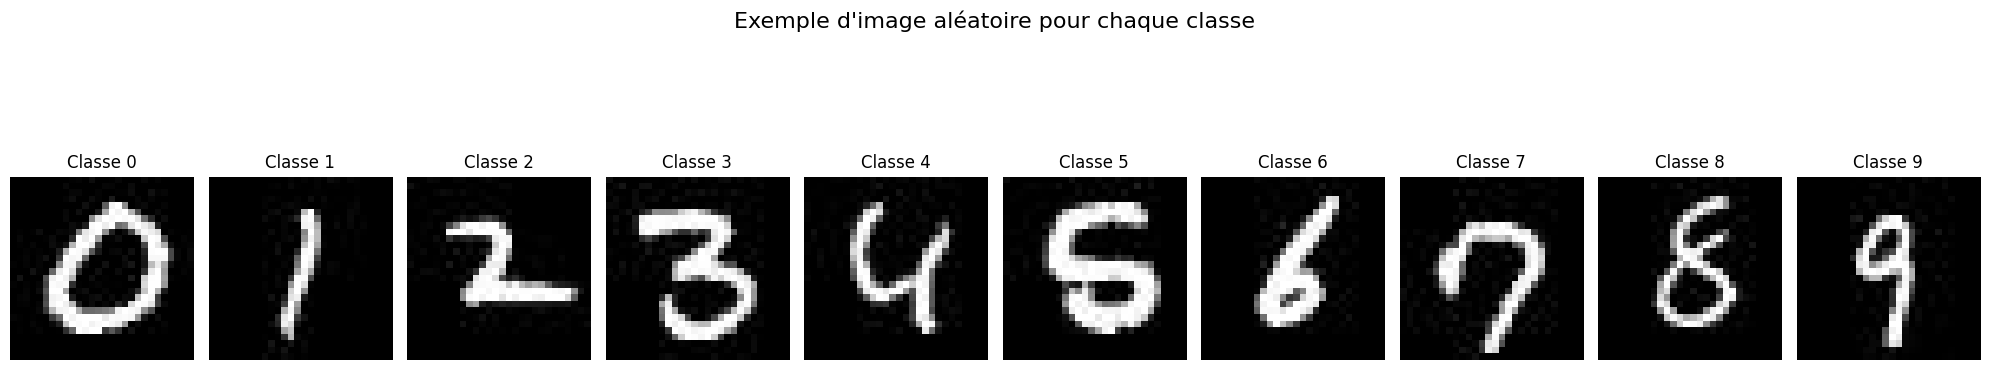

In [32]:
# Chaque répertoire dans "path" contient des images du chiffre indiqué.
# Affichez 1 example d'images de chaque classe dans une seule figure.
# Pour ça, on va choisir une image aléatoire dans chaque répertoire de path et l'afficher. 

from matplotlib.image import imread

def display_random_images(path):
    """Affiche une image aléatoire de chaque classe (0 à 9) dans une seule figure."""
    if not os.path.isdir(path):
        print(f"Le chemin '{path}' n'est pas un répertoire valide.")
        return
    
    # Initialiser la figure
    fig, axes = plt.subplots(1, 10, figsize=(20, 5))
    fig.suptitle("Exemple d'image aléatoire pour chaque classe", fontsize=16)
    
    for i in range(10):  # Les classes vont de 0 à 9
        class_path = os.path.join(path, str(i))
        
        if not os.path.isdir(class_path):
            print(f"Le répertoire pour la classe '{i}' est manquant.")
            axes[i].axis('off')
            continue
        
        # Liste des fichiers d'images dans le répertoire
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        if not images:
            print(f"Aucune image trouvée dans la classe '{i}'.")
            axes[i].axis('off')
            continue
        
        # Choisir une image aléatoire
        random_image = random.choice(images)
        image_path = os.path.join(class_path, random_image)
        
        # Lire et afficher l'image
        image = imread(image_path)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Classe {i}")
    
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation :
path = "/Users/hemmalizee/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/trainingSample/trainingSample"
display_random_images(path)

## 2. Chargement des images

In [33]:
debug = 0

def load(paths, verbose=-1):
    '''
    Charge les images à partir des chemins spécifiés.
    '''
    # Initialisez 2 listes : data et labels
    data = []
    labels = []

    # Boucle sur les chemins des images
    for (i, imgpath) in enumerate(paths):
        # Chargement de l'image en niveaux de gris à l'aide d'OpenCV
        gray_image = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        if gray_image is None:
            if debug:
                print(f"Impossible de charger l'image : {imgpath}")
            continue
        
        # Aplatissement de l'image en un tableau unidimensionnel
        image = np.array(gray_image).flatten()

        # Extraction de l'étiquette à partir du chemin de l'image (nom du répertoire)
        label = imgpath.split(os.path.sep)[-2]

        # Mettez à l'échelle les images à [0, 1] et ajoutez-les à la liste data
        image = image / 255.0  # Normalisation (Les valeurs de pixels (de 0 à 255) sont normalisées pour être comprises entre 0 et 1)
        data.append(image)

        # Ajoutez les étiquettes à la liste labels
        labels.append(label)

        # Si verbose > 0, affichez l'avancement
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print(f"[INFO] Traitement de l'image {i + 1}/{len(paths)}")

    # Retournez un tuple contenant les données et les étiquettes
    return (np.array(data), np.array(labels))


## 3. Creation des clients

In [34]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    '''
    Crée des clients pour l'apprentissage fédéré.

    Args:
        - image_list (list): Liste d'arrays numpy représentant les images d'entraînement.
        - label_list (list): Liste d'étiquettes binarisées pour chaque image.
        - num_clients (int, optional): Nombre de membres de la fédération (clients). Par défaut, 100.
        - initial (str, optional): Préfixe des noms de clients. Par exemple, 'clients_1'. Par défaut, 'clients'.

    Returns:
        dict: Un dictionnaire avec les noms des clients comme clés et les données (images et étiquettes) comme valeurs.
    '''

    # Création d'une liste de noms de clients
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    # Mélange aléatoire des données (IID - Independently and Identically Distributed)
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    # Si vous voulez un ordre non-IID (non-Indépendamment et Identiquement Distribué),
    # decommentez les lignes suivantes
    # max_y = np.argmax(label_list, axis=-1)
    # sorted_zip = sorted (zip(max_y, label_list, image_list), key-lambda x: x[®])
    # data = [(x, y) for _, y, x in sorted_ zip]

    # Divise les données en shards et les attribue à chaque client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    # assurez vous que le nombre de clients soit égal au nombre de shards
    assert (len(client_names) == len(shards))

    # Retournez un dictionnaire avec les noms des clients comme clés et les données (shards) comme valeurs
    dict_name_shards = {client_names[i]: shards[i] for i in range(num_clients)}
    return dict_name_shards

## 4. Création des batchs

In [35]:
def batch_data(data_shard, bs=32):
    '''
    Prend en charge un ensemble de données d'un client et crée un objet tfds (TensorFlow Dataset).

    Args:
        - data_shard (list): Liste des données et des étiquettes constituant l'ensemble de données d'un client.
        - bs (int, optional): Taille du lot (batch size). Par défaut, 32.

    Returns:
        tf.data.Dataset: Objet TensorFlow Dataset.
    '''
    # Sépare l'ensemble de données en listes de données et d'étiquettes
    data, label = zip(*data_shard)
    data = list(data)
    label = list(label)

    # Créez un objet TensorFlow Dataset à partir des listes de données et d'étiquettes
    dataset = tf.data.Dataset.from_tensor_slices((data, label))

    # Mélange le dataset et crée des lots de la taille spécifiée
    return dataset.shuffle(len(label)).batch(bs)


## 5. Mise a l'échelle des poids d'un modèle

In [36]:
def scale_model_weights(weight, scalar):
    '''
    Fonction pour mettre à l'échelle les poids d'un modèle.

    Args:
        - weight (list): Liste des poids du modèle.
        - scalar (float): Facteur d'échelle.

    Returns:
        - list: Liste des poids du modèle mis à l'échelle.
    '''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        # Mettez à l'échelle les poids et ajoutez-les à la liste weight_final
        scaled_weight = scalar * weight[i]
        weight_final.append(scaled_weight)
    return weight_final


## 6. La somme des poids mis à l'échelle

In [37]:
def sum_scaled_weights(scaled_weight_list):
    '''
    Retourne la somme des poids mis à l'échelle.

    Args:
        - scaled_weight_list (list): Liste des poids mis à l'échelle.

    Returns:
        list: Somme des poids mis à l'échelle, équivalent à la moyenne pondérée des poids.
    '''
    avg_grad = list()

    # Obtient la moyenne des gradients à travers tous les clients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad

## 7. Création du modèle

In [38]:
def test_model(X_test, Y_test,  model, comm_round):
    # Computes the crossentropy loss between the labels and predictions:
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    # La perte utilisée est l'entropie croisée catégorielle, appropriée pour des tâches de classification multi-classes.
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [50]:
#Voici un modèle simple de perceptron multicouche (MLP) pour la classification en utilisant Keras. Il se compose de plusieurs couches entièrement connectées (fully connected layers).

class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        '''
        Créez un modèle de classification MLP simple.

        Args:
            - shape (tuple): La forme des données d'entrée (par exemple, (28, 28) pour des images de taille 28x28).
            - classes (int): Le nombre de classes pour la classification.

        Returns:
            model: Le modèle construit.
        '''
        # Définir le modèle
        model = tf.keras.Sequential()
        
        # Ajouter la couche d'entrée (flatten) pour aplatir les données d'entrée
        model.add(tf.keras.layers.Flatten(input_shape=(shape,)))  # Si shape = (28, 28), cela aplatit l'entrée en vecteur
        
        # Ajouter une première couche dense avec 128 neurones et activation ReLU
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        
        # Ajouter une deuxième couche dense avec 64 neurones et activation ReLU
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        
        # Ajouter la couche de sortie avec le nombre de classes et activation softmax pour la classification multiclasses
        model.add(tf.keras.layers.Dense(classes, activation='softmax'))
        
        # Compiler le modèle avec une fonction de perte pour la classification multiclasses et un optimiseur Adam
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        
        return model

In [40]:
#chemin du training set
img_path = '/Users/hemmalizee/.cache/kagglehub/datasets/scolianni/mnistasjpg/versions/1/trainingSet/trainingSet'

#Obtenez la liste des chemins en utilisant l'objet path
image_paths = list(paths.list_images(img_path))

# utilisez la fonction load pour recupérer la liste des images/labels
image_list, label_list = load(image_paths, verbose=-1)

#Binarisez les étiquettes(labels) en utilisant LabelBinarizer de sklearn
label_binarizer = LabelBinarizer()
label_list = label_binarizer.fit_transform(label_list)

In [41]:
#Divisez les données en ensembles d'entraînement et de test 80% train  20% test
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state=42)

In [42]:
#Créez vos clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [43]:
#traitement et regroupement des données d'entraînement pour chaque client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

#test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [58]:
lr = 0.01

# Choisissez le nombre de rounds (epochs)
comms_round = 20  # Par exemple, 20  (rounds) d'entraînement

loss = 'categorical_crossentropy'
metrics = ['accuracy']
optimizer = "sgd"  # Stochastic Gradient Descent (SGD)


In [51]:
build_shape = 784

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10)
global_acc_list = []
global_loss_list = []

## 8. Différentes tentatives d'entrainement et test de performances

In [61]:
# Débutez la boucle d'entraînement globale

for comm_round in range(comms_round): 
    # Obtenez les poids du modèle global
    global_weights = global_model.get_weights()

    # Créez une liste pour les poids locaux mis à l'échelle
    scaled_local_weight_list = list()

    #Choisir 10 clients random pour chaque tour
    all_client_names = list(clients_batched.keys())
    client_names = random.sample(all_client_names, 100) #100 clients

    # Parcourez chaque client et créez un nouveau modèle local
    for client_name in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

        # Affecter les poids du modèle global au model local
        local_model.set_weights(global_weights)

        #fit local model avec  les données du client
        local_model.fit(clients_batched[client_name], epochs=1, verbose=0)

        #mettre à l'échelle les poids d'un modèle
        scaling_factor = 0.01  
        scaled_weights = [scaling_factor * w for w in local_model.get_weights()]

        # Ajouter les poids mis à l'échelle à la liste
        scaled_local_weight_list.append(scaled_weights)

        # Libérer la session Keras pour éviter les fuites de mémoire
        K.clear_session()

    #faire la somme des poids mis à l'échelle en utilisant la fonction sum_scaled_weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #Affecter la moyenne des poids local au model global
    global_model.set_weights(average_weights)


    #Testez le modèle global et afficher les métriques après chaque tour de communication
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

263/263 [==============================] - 0s 281us/step
comm_round: 0 | global_acc: 83.738% | global_loss: 1.8041455745697021
263/263 [==============================] - 0s 357us/step
comm_round: 1 | global_acc: 83.952% | global_loss: 1.7987936735153198
263/263 [==============================] - 0s 303us/step
comm_round: 2 | global_acc: 84.214% | global_loss: 1.7934530973434448
263/263 [==============================] - 0s 292us/step
comm_round: 3 | global_acc: 84.405% | global_loss: 1.7886004447937012
263/263 [==============================] - 0s 302us/step
comm_round: 4 | global_acc: 84.560% | global_loss: 1.783903956413269
263/263 [==============================] - 0s 283us/step
comm_round: 5 | global_acc: 84.679% | global_loss: 1.7793868780136108
263/263 [==============================] - 0s 278us/step
comm_round: 6 | global_acc: 84.798% | global_loss: 1.7751448154449463
263/263 [==============================] - 0s 332us/step
comm_round: 7 | global_acc: 84.940% | global_loss: 1.77

Avec 10 rounds et 10 clients:

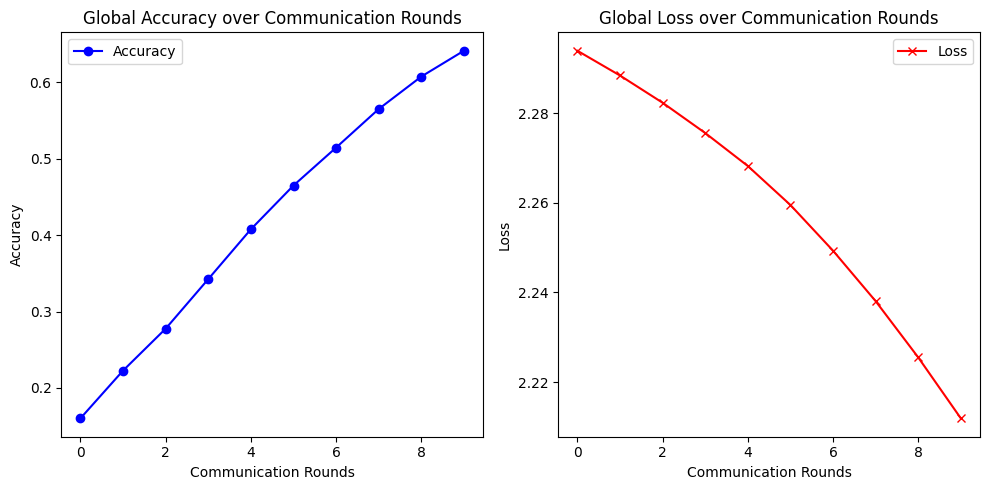

In [54]:
# Affichage du graphique pour l'accuracy
plt.figure(figsize=(10, 5))  # Taille de la figure

# Tracer l'accuracy
plt.subplot(1, 2, 1)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_acc_list, label='Accuracy', color='blue', linestyle='-', marker='o')
plt.title('Global Accuracy over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.legend()

# Affichage du graphique pour la loss
plt.subplot(1, 2, 2)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_loss_list, label='Loss', color='red', linestyle='-', marker='x')
plt.title('Global Loss over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')
plt.legend()

# Affichage des deux graphes
plt.tight_layout()
plt.show()

Avec 10 rounds et 30 clients:

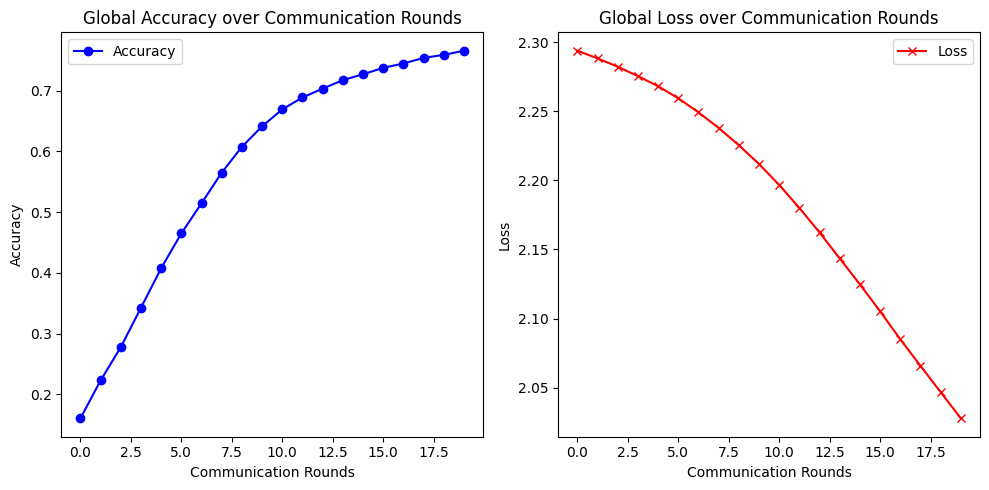

In [57]:
# Affichage du graphique pour l'accuracy
plt.figure(figsize=(10, 5))  # Taille de la figure

# Tracer l'accuracy
plt.subplot(1, 2, 1)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_acc_list, label='Accuracy', color='blue', linestyle='-', marker='o')
plt.title('Global Accuracy over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.legend()

# Affichage du graphique pour la loss
plt.subplot(1, 2, 2)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_loss_list, label='Loss', color='red', linestyle='-', marker='x')
plt.title('Global Loss over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')
plt.legend()

# Affichage des deux graphes
plt.tight_layout()
plt.show()

Avec 20 rounds et 30 clients:

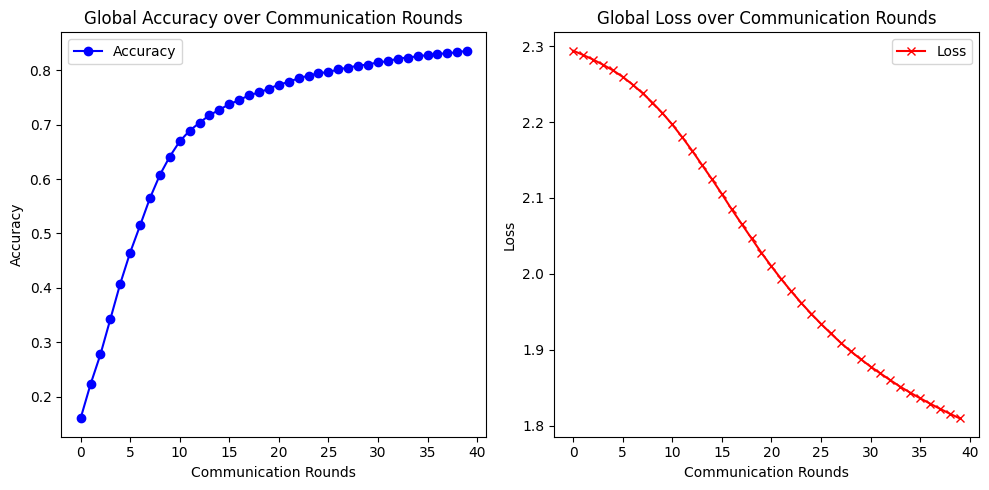

In [60]:
# Affichage du graphique pour l'accuracy
plt.figure(figsize=(10, 5))  # Taille de la figure

# Tracer l'accuracy
plt.subplot(1, 2, 1)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_acc_list, label='Accuracy', color='blue', linestyle='-', marker='o')
plt.title('Global Accuracy over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.legend()

# Affichage du graphique pour la loss
plt.subplot(1, 2, 2)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_loss_list, label='Loss', color='red', linestyle='-', marker='x')
plt.title('Global Loss over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')
plt.legend()

# Affichage des deux graphes
plt.tight_layout()
plt.show()

Avec 20 rounds et tous les clients (100):

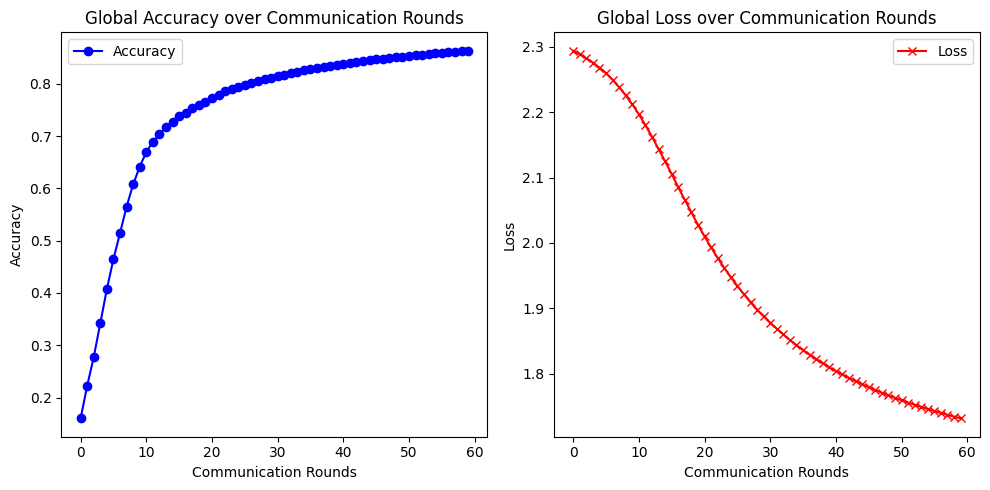

In [62]:
# Affichage du graphique pour l'accuracy
plt.figure(figsize=(10, 5))  # Taille de la figure

# Tracer l'accuracy
plt.subplot(1, 2, 1)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_acc_list, label='Accuracy', color='blue', linestyle='-', marker='o')
plt.title('Global Accuracy over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.legend()

# Affichage du graphique pour la loss
plt.subplot(1, 2, 2)  # (1, 2) représente 1 ligne et 2 colonnes de sous-graphes
plt.plot(global_loss_list, label='Loss', color='red', linestyle='-', marker='x')
plt.title('Global Loss over Communication Rounds')
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')
plt.legend()

# Affichage des deux graphes
plt.tight_layout()
plt.show()